In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import sys
from tqdm import tqdm
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix_project/psix/psix/')
import psix

In [2]:
psix_object = psix.Psix()
psix_object.process_smartseq(
        'data/SE_counts.tab.gz',
        'data/constitutive_introns.tab.gz',
        'data/rsem_gene_tpm.tab.gz',
        minJR = 1,
        minCell=1,
        min_observed = 0.25)

Obtaining psi tables...
Reading TPM and transforming to mRNA counts...


100%|██████████| 488/488 [00:34<00:00, 13.96it/s]


Successfully processed smart-seq data


In [3]:
psix_object.compute_psix_scores(latent='data/preprocess/pc2_rd.tab.gz', n_jobs=25, n_random_exons=2000, n_neighbors=30)

  3%|▎         | 17/488 [00:00<00:02, 162.39it/s]

cell-cell metric not found. Computing metric...
Obtaining cell-cell neighbors and weights


100%|██████████| 488/488 [00:02<00:00, 176.87it/s]

Successfully computed cell-cell metric
Computing Psix score in 2105 exons



100%|██████████| 2105/2105 [00:10<00:00, 209.70it/s]


Successfully computed Psix score of exons.
...

Estimating p-values. This might take a while...


100%|██████████| 25/25 [03:58<00:00,  9.53s/it]


Successfully estimated p-values


In [4]:
psix_results = psix_object.psix_results
psix_results.head()

psix_score   pvals     qvals
Clta_2        1.815228  0.0005  0.003416
Slc25a25_1    0.866486  0.0005  0.003416
Apbb1_3       0.826984  0.0005  0.003416
Mta1_5        0.780785  0.0005  0.003416
Meaf6_2       0.753028  0.0005  0.003416

In [7]:
psix_object.save_psix_object(overwrite=True)

In [8]:
488 - (psix_object.adata.uns['cell_metric'] == 0).sum(axis=1)

cell
SRR2727045    30
SRR2727046    30
SRR2727047    30
SRR2727048    30
SRR2727049    30
              ..
SRR3211942    30
SRR3211943    30
SRR3211944    30
SRR3211945    30
SRR3211946    30
Length: 488, dtype: int64

In [6]:
psix_object.compute_neighbors_psi(remove_self=False)

slicing exons...


100%|██████████| 2105/2105 [00:03<00:00, 691.97it/s]

Successfully computed neighbors


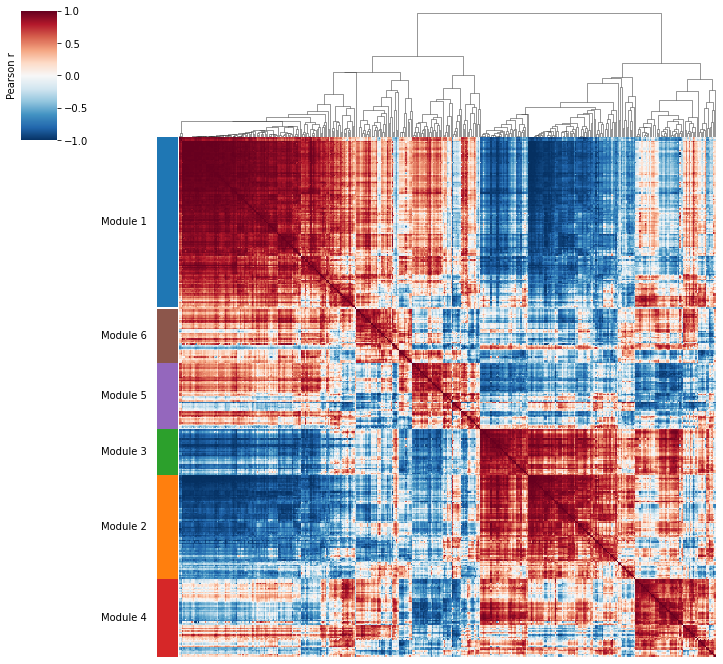

In [9]:
import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix_project/analysis_psix/utils/')
from misc_utils import *

background_psi = psix_object.adata.uns['neighbors_psi'].mask(psix_object.adata.uns['psi'].isna()).T
exon_list = psix_results.loc[(psix_results.psix_score > 0) & (psix_results.qvals <= 0.05)].index

bwow = compute_modules(background_psi.loc[exon_list].T.corr().fillna(0), 
                min_gene_threshold=30, fdr_threshold=None, z_threshold=0.3, core_only=False)

aver = local_correlation_plot(
            background_psi.loc[exon_list].T.corr().fillna(0), bwow[0], bwow[1],
            mod_cmap='tab10', vmin=-1, vmax=1,
            z_cmap='RdBu_r', yticklabels=False
)

(2.0, 4.0)

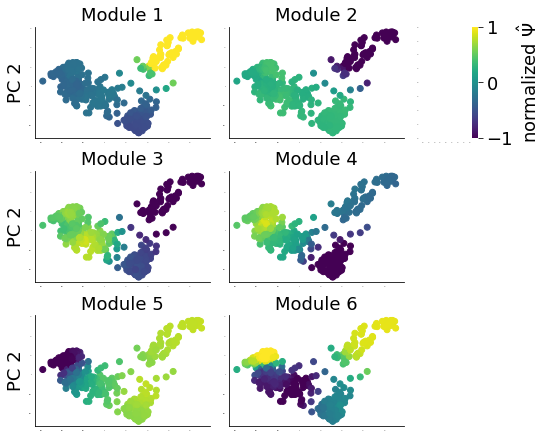

In [12]:
from scipy.stats import zscore
from itertools import product
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 10))
gs = GridSpec(4,12)
gs.update(wspace=1, hspace=0.3)

ax_positions = list(product(range(3), range(2)))

background_psi = psix_object.adata.uns['neighbors_psi'].T

for mod in range(1, 7):
    
    mad_df = pd.DataFrame()
    for exon in bwow[0].index[bwow[0]==mod]:
        mad_df[exon] = zscore(background_psi.loc[exon, psix_object.adata.uns['psi'].index])
    mad_df.index= psix_object.adata.uns['psi'].index
    
    x, y = ax_positions[mod-1]
    
    ax = fig.add_subplot(gs[x,(5*y):(5*y)+5])

    sc = ax.scatter(psix_object.adata.uns['latent'].PC_1, 
                    -psix_object.adata.uns['latent'].PC_2, 
                    c=mad_df.mean(axis=1), vmin=-1, vmax=1, cmap='viridis')
    
    
    plt.title('Module '+str(mod), fontsize=18)
    if x == 3:
        plt.xlabel('PC 1', fontsize=18)
    if y == 0:
        plt.ylabel('PC 2', fontsize=18)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(labelsize=0, length=0)
    ax.grid(False)
#     plt.show()
ax = fig.add_subplot(gs[0,10:12])
ax.grid(False)
sc = ax.scatter([0, 0], [0, 0], c=[-1, 1])
cb = plt.colorbar(sc, shrink = 1, aspect=20)
cb.set_label(label='normalized $\hat{\Psi}$',size=18)
cb.ax.tick_params(labelsize=18, length=5)
cb.outline.set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.tick_params(labelsize=0, length=0)
ax.set_xlim((2, 4))
ax.set_ylim((2, 4))

In [24]:
bwow[0].index[bwow[0] == 2]

Index(['Clta_2', 'Slc25a25_1', 'Meaf6_2', 'Arvcf_5', 'Sgce_1', 'Apbb1_3',
       'Chchd3_9', 'Exoc1_1', 'Abi2_4', 'Slc25a14_7', 'Sgce_5',
       'Mtfr1_nmdSE_1', 'Ncam1_4', 'Arhgef7_4', 'Mff_4', 'Tpd52_4', 'Cers5_5',
       'Kif2a_9', 'Dpf2_2', 'Bin1_9', 'Porcn_4', 'Exoc7_4', 'Fbxo25_1',
       'Asph_5', 'Abi1_9', 'Tpd52l2_3', 'Elmo2_2', 'Lman2l_7', 'Snx14_1',
       'Plod2_2', 'Dync1i2_2', 'Psap_3', 'Gripap1_10', 'Cstf2_2', 'Pdlim7_8',
       'Zmynd8_8', 'Nsfl1c_5', 'H13_6', 'Dmd_2', 'Dst_5', 'Faim_2', 'Fez2_1',
       'Zc3h11a_11', 'Fat1_7', 'Lrrfip1_10', 'G2e3_3', 'Tjap1_1', 'Lrrfip1_7',
       'Cstf2_3', 'Meaf6_nmdSE_2', 'Mef2d_8', 'Mon2_1', 'Prrc2b_4', 'Fmr1nb_3',
       'Nxt1_1', 'Mff_7', 'Smtn_3', 'Acsl3_1', 'Atp2c1_4', 'Idh3g_5',
       'Ankrd12_2', 'March7_3', 'Rbm25_6', 'Picalm_4', 'Plekha1_4', 'Pcmtd1_1',
       'Mllt4_4', 'Plekha1_8', 'Ppip5k2_5', 'Ankrd10_nmdSE_2', 'Ssbp4_15',
       'Osbpl9_10', 'Atg16l1_2', 'Lrrfip1_1', 'Ap2b1_6', 'Ndrg3_6', 'Ssbp4_7',
       'Adgrl2_13'

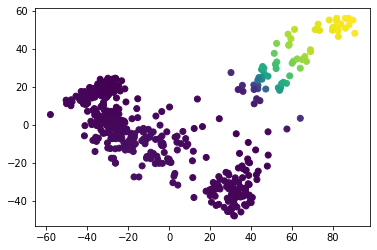

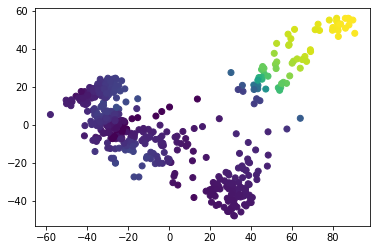

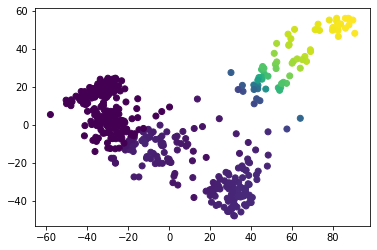

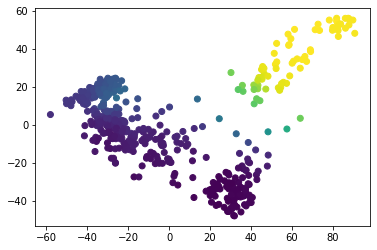

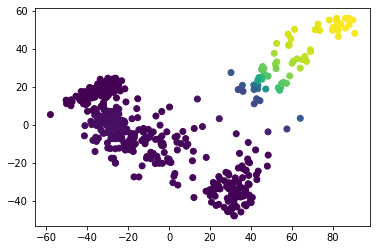

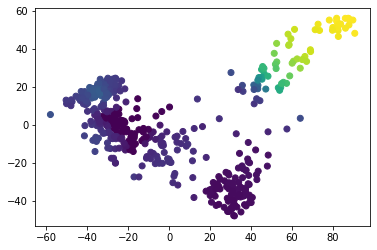

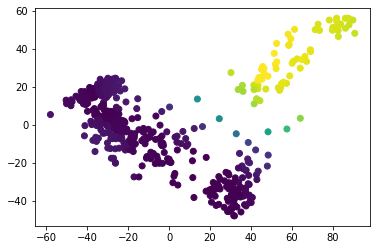

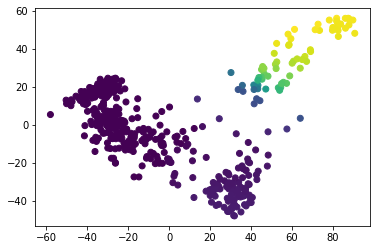

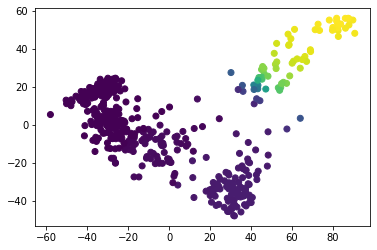

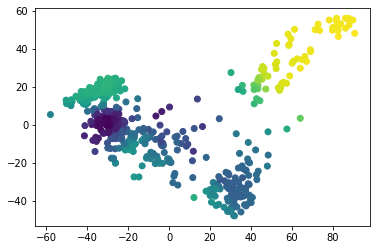

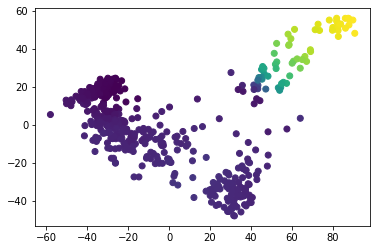

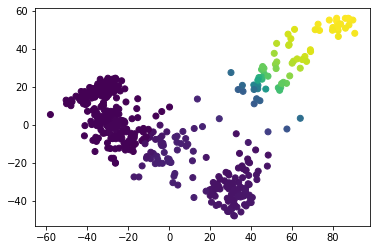

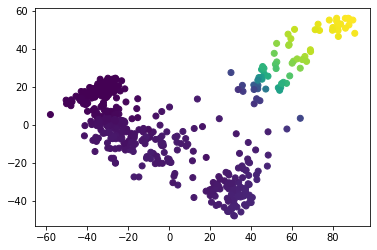

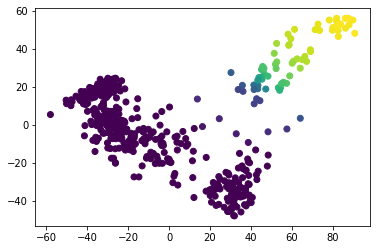

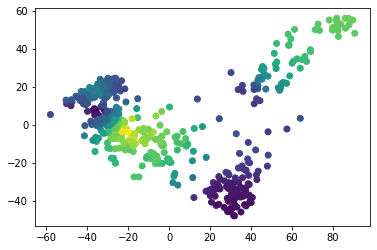

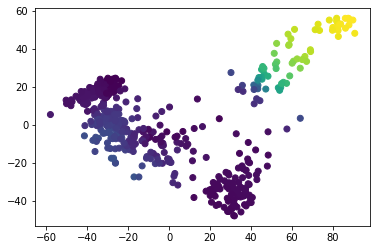

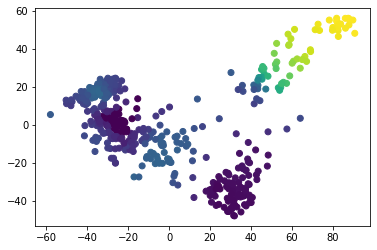

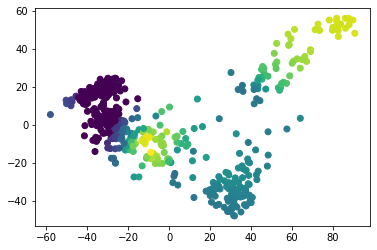

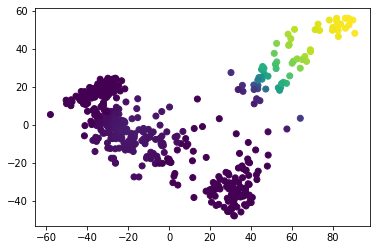

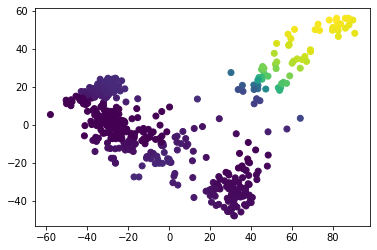

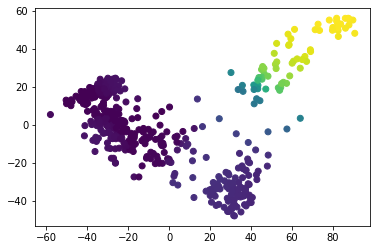

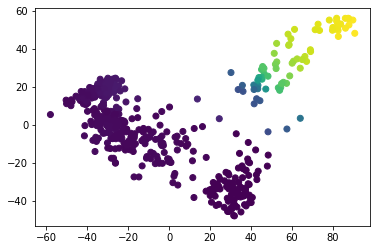

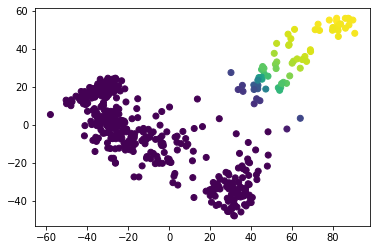

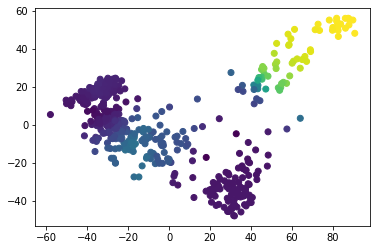

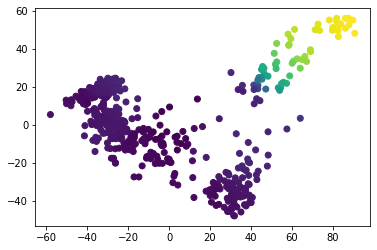

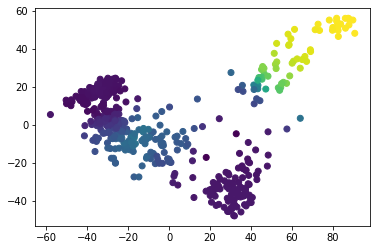

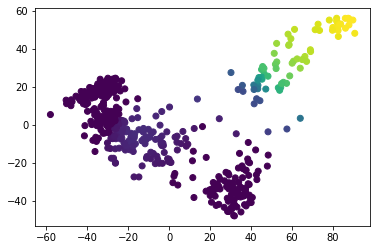

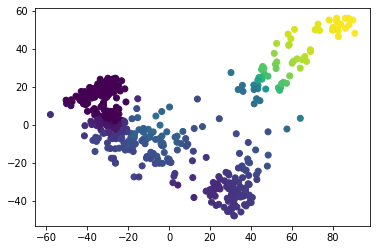

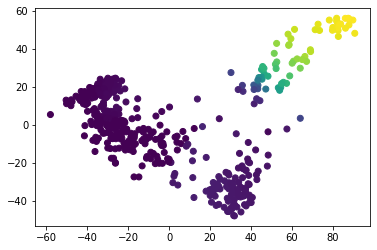

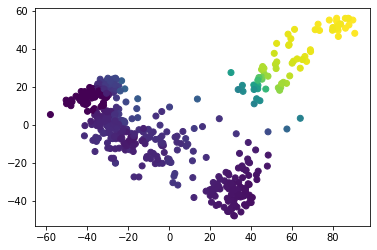

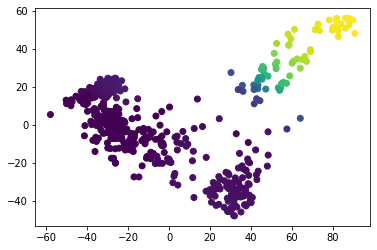

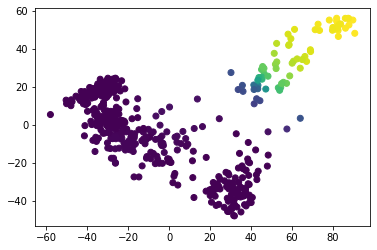

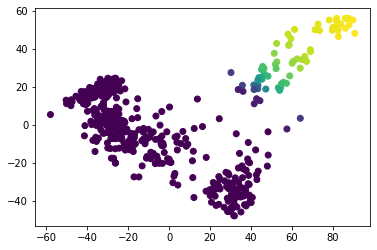

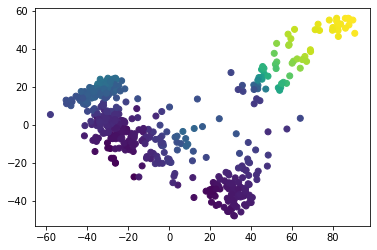

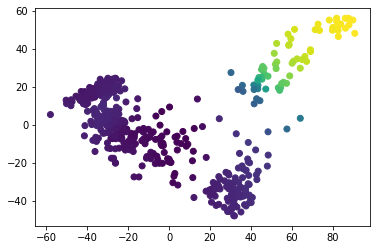

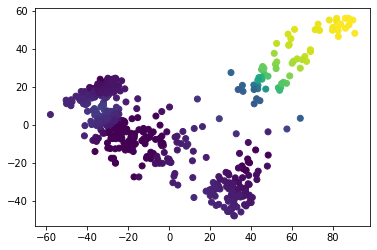

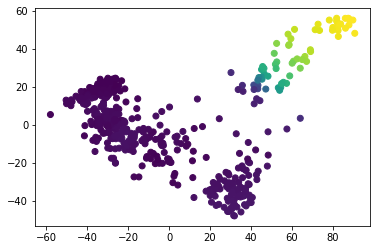

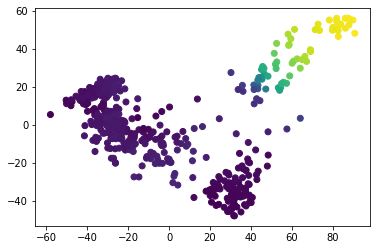

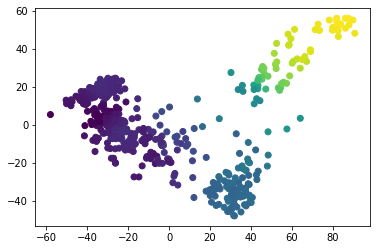

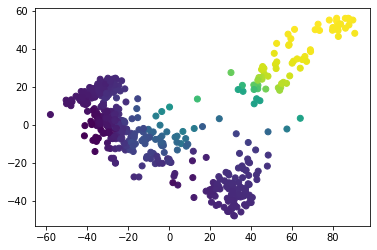

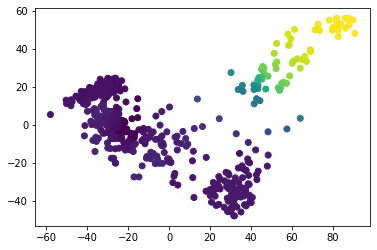

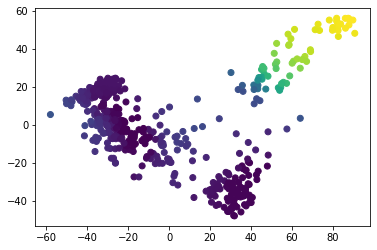

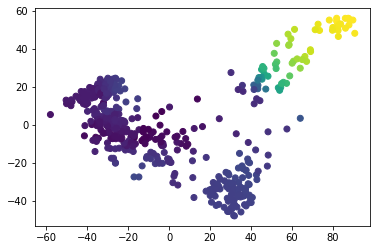

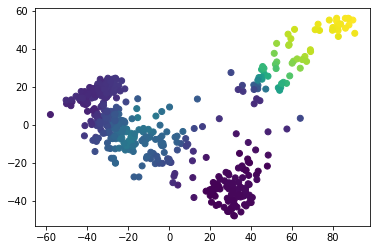

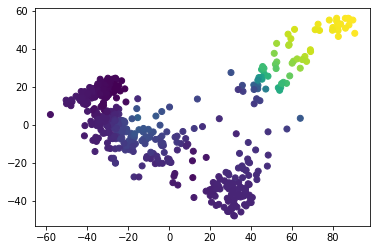

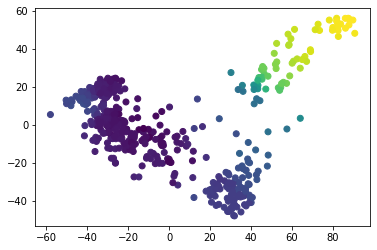

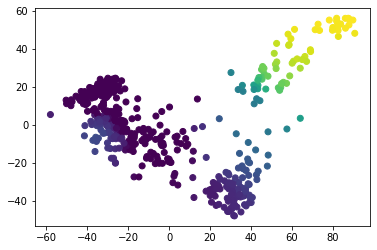

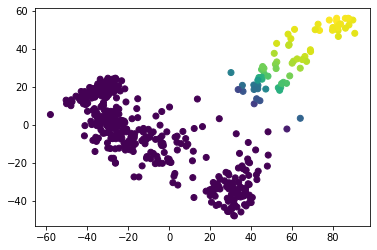

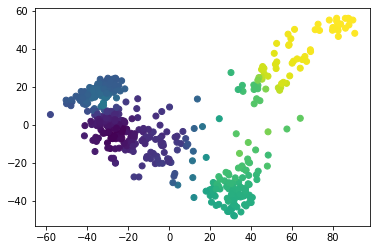

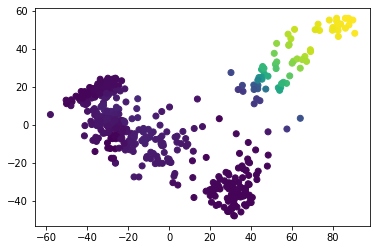

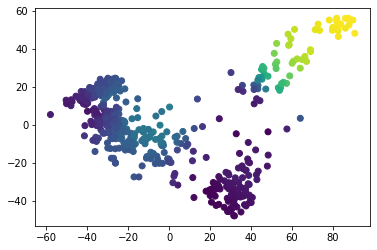

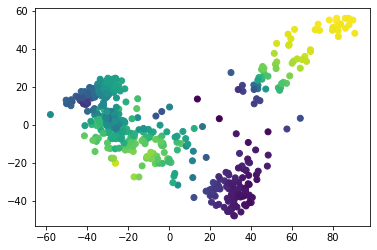

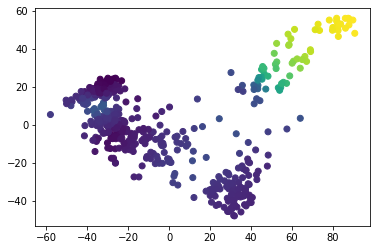

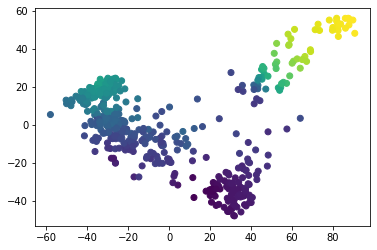

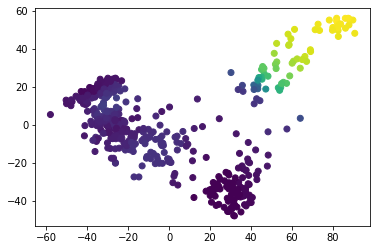

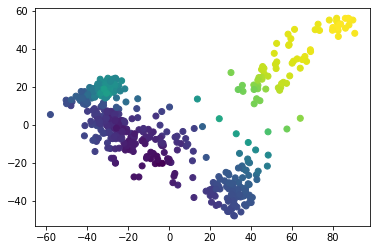

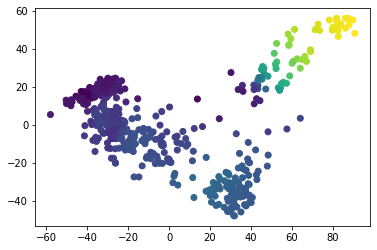

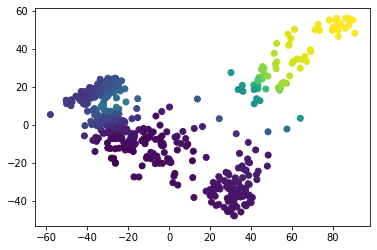

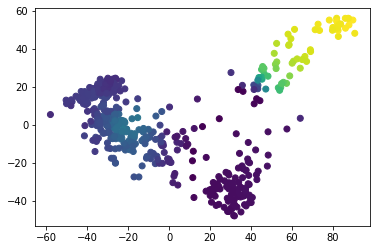

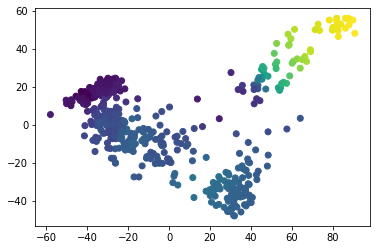

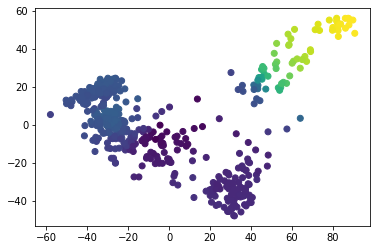

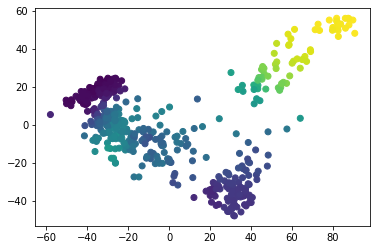

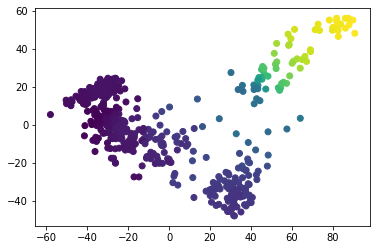

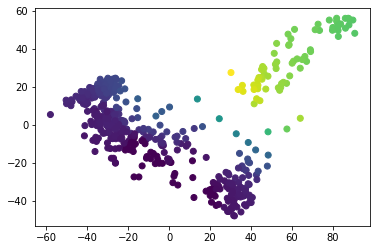

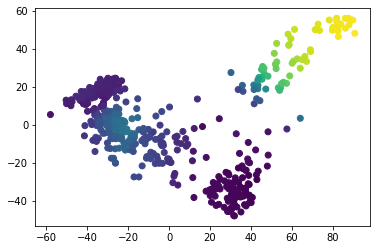

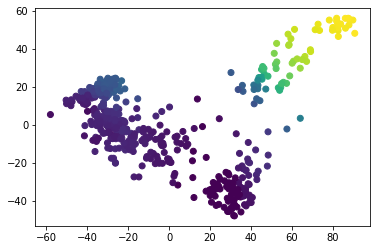

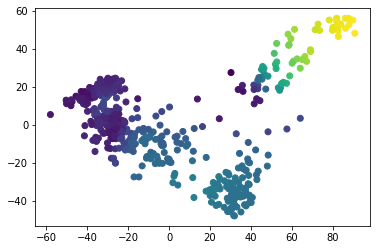

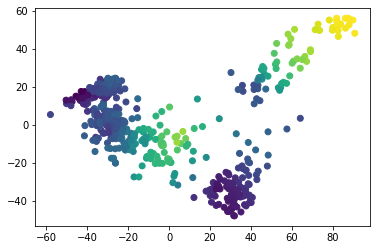

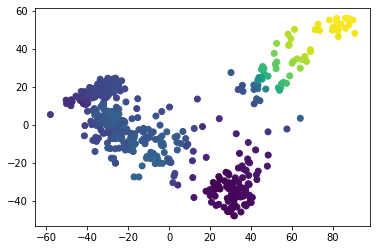

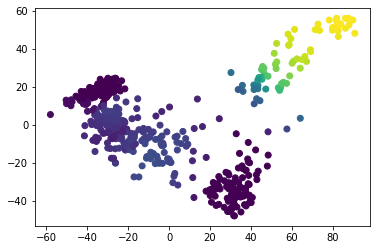

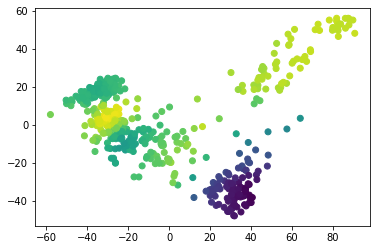

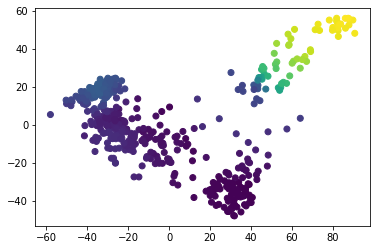

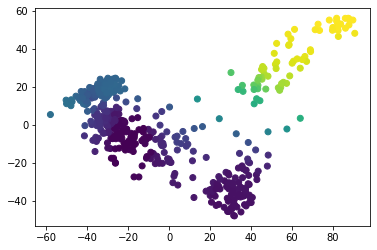

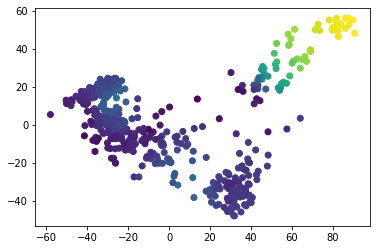

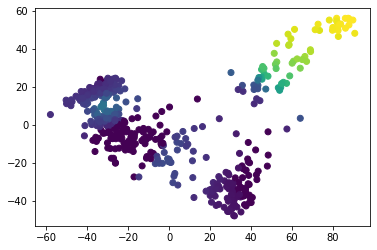

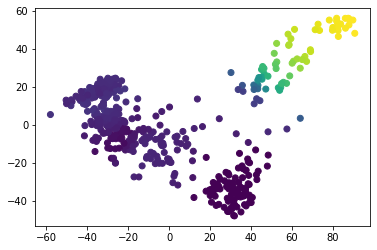

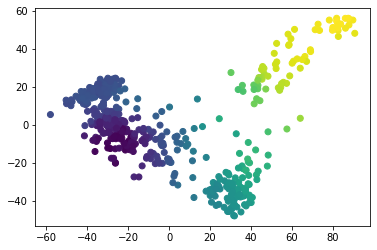

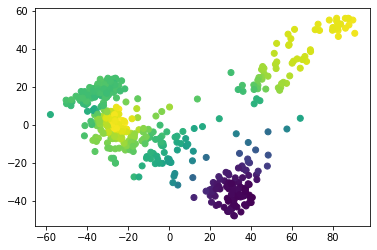

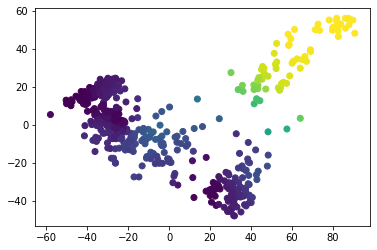

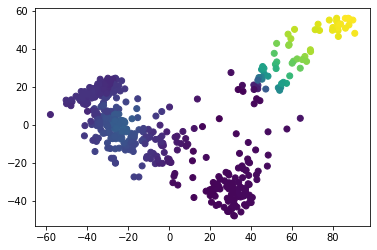

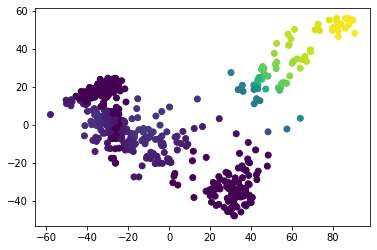

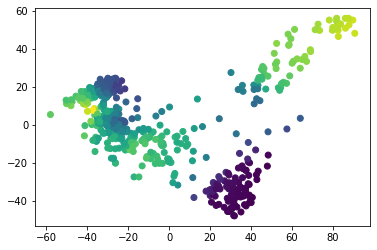

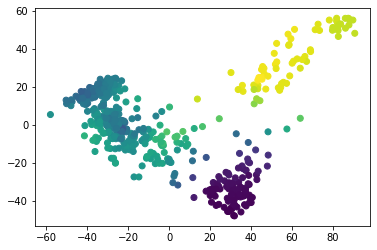

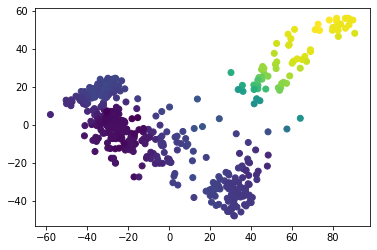

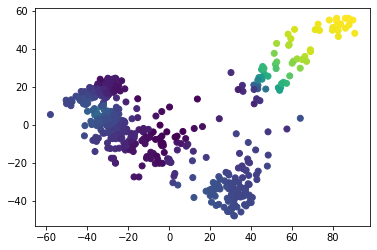

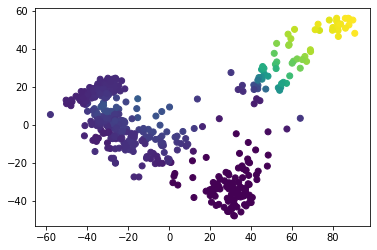

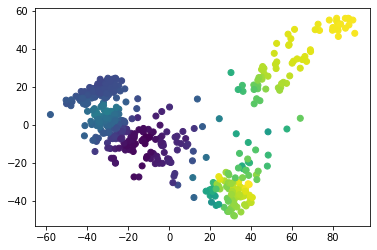

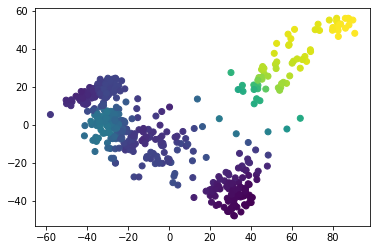

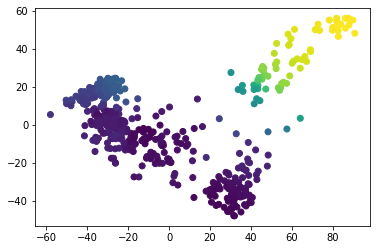

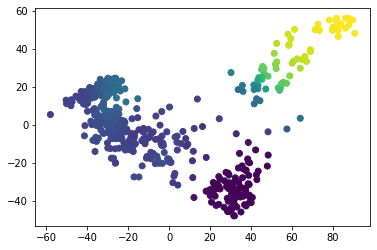

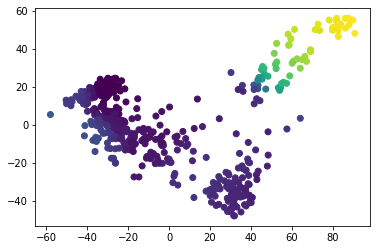

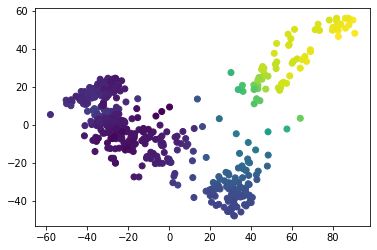

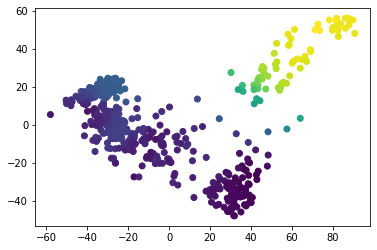

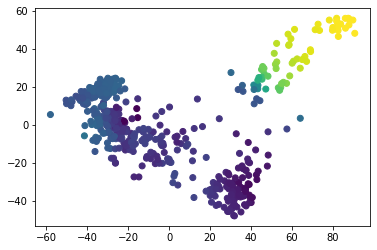

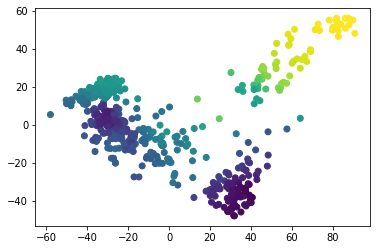

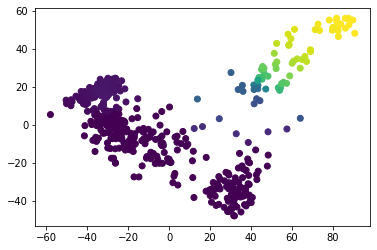

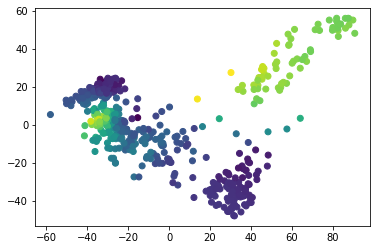

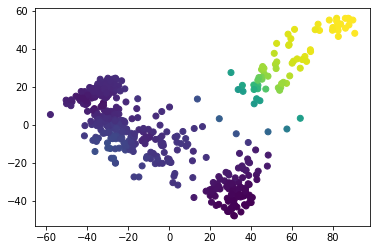

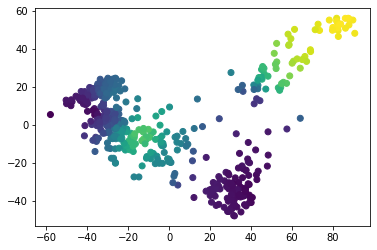

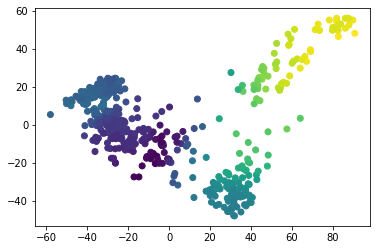

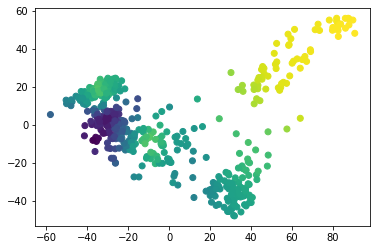

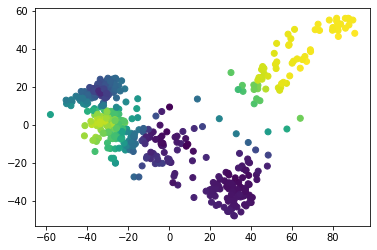

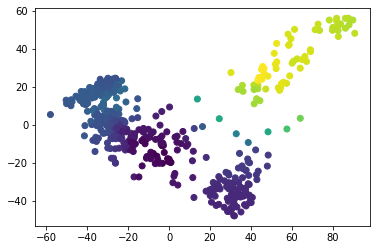

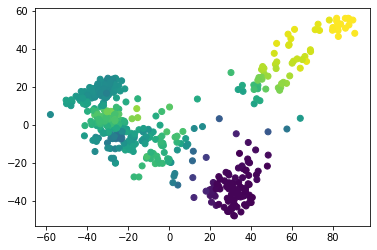

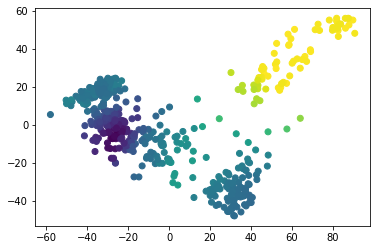

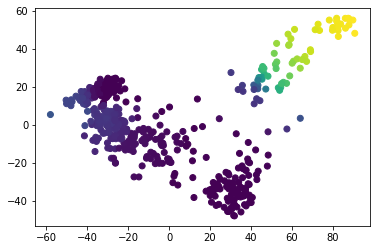

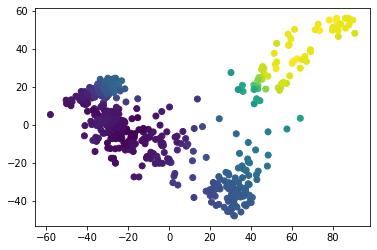

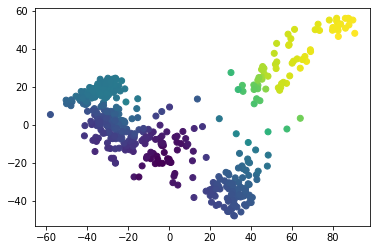

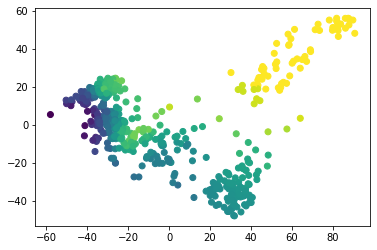

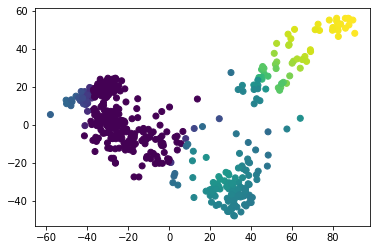

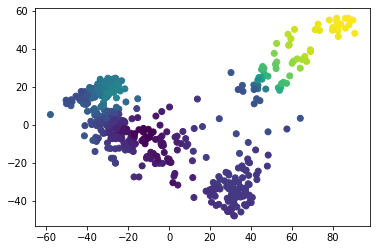

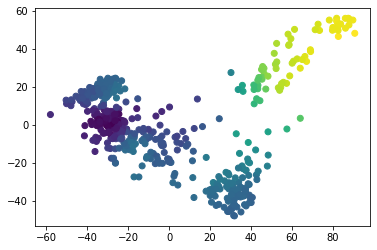

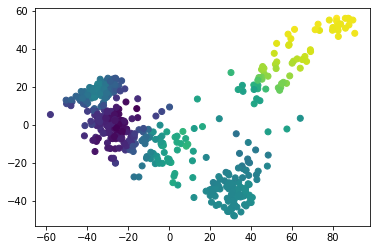

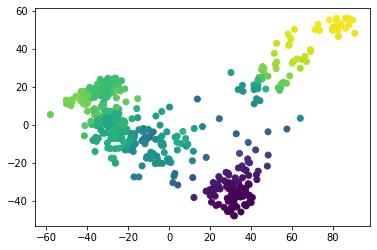

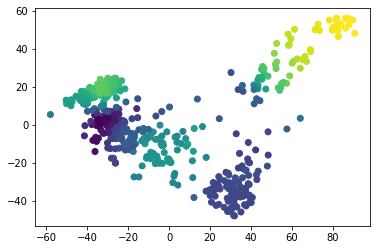

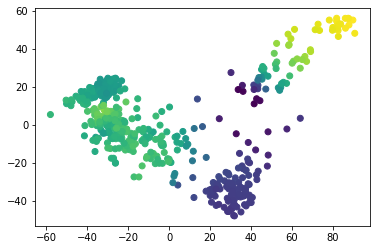

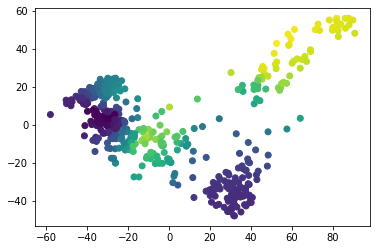

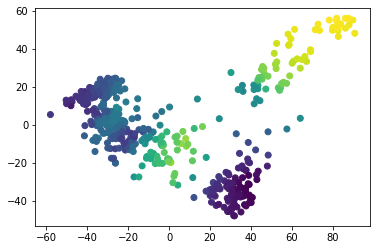

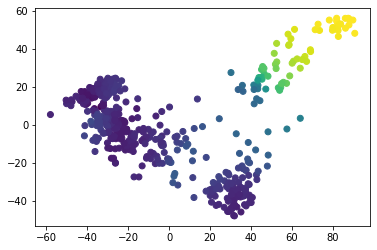

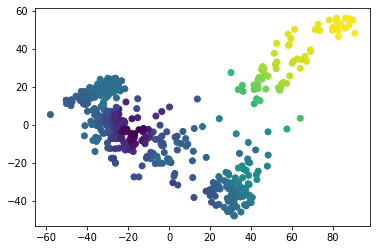

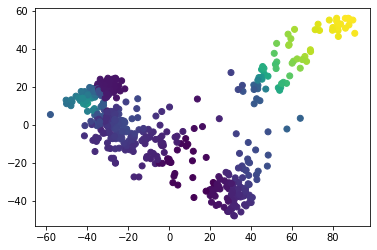

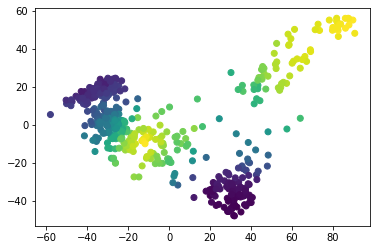

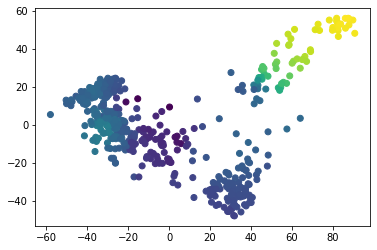

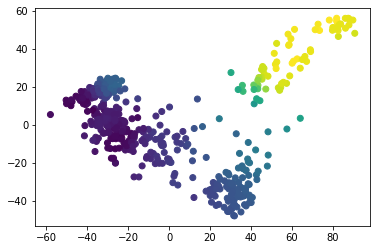

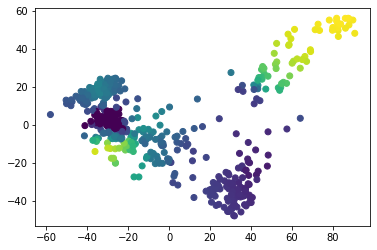

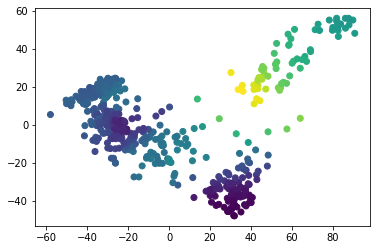

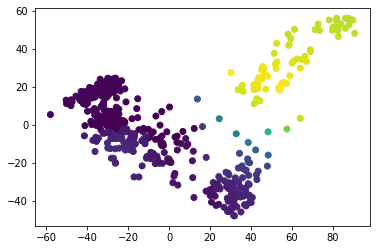

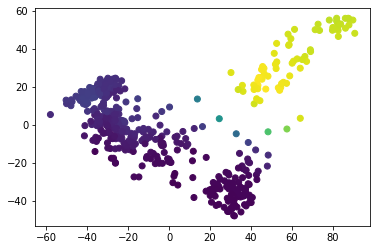

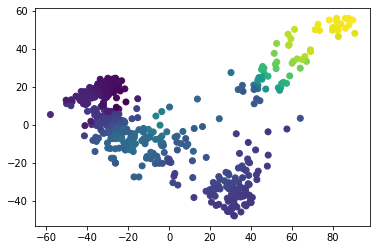

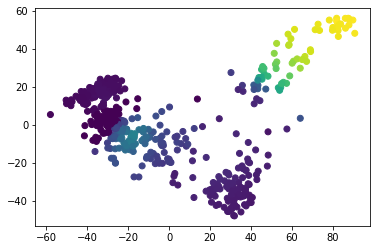

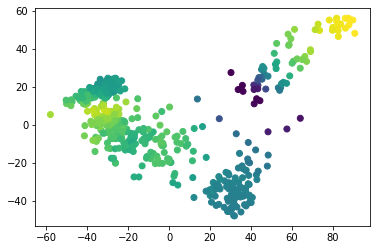

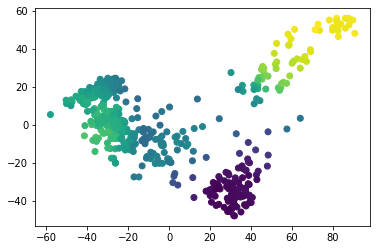

In [10]:
for exon in bwow[0].index[bwow[0] == 1]:
    plt.scatter(psix_object.adata.uns['latent'].PC_1, 
                    -psix_object.adata.uns['latent'].PC_2, 
            c = psix_object.adata.uns['neighbors_psi'].loc[psix_object.adata.uns['latent'].index, exon])
    plt.show()

(array([106.,  20.,  28.,  26.,  20.,  28.,  11.,   7.,   5.,  92.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

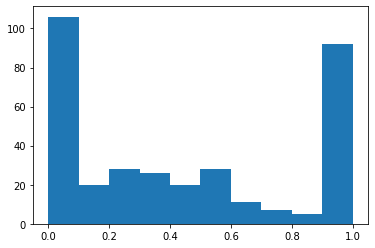

In [19]:
plt.hist(psix_object.adata.uns['psi']['Cadm1_9'])

In [60]:
[x for x in psix_object.adata.uns['psi'].columns if 'Rpn2' in x]

['Rpn2_3']

In [23]:
meta = pd.read_csv('data/meta.tab.gz', sep='\t', index_col=0)

(-2.0, 30.0)

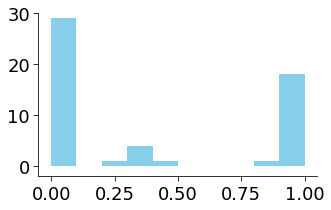

In [63]:
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(psix_object.adata.uns['psi'].loc[meta.index[meta.cell_type == 'ES'], 'Cadm1_9'], color='skyblue')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=18, length=5)
ax.set_ylim((-2, 30))

(-2.0, 18.0)

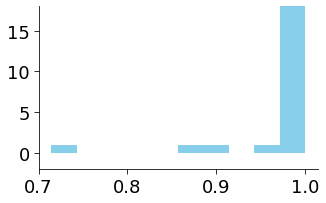

In [58]:
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(psix_object.adata.uns['psi'].loc[real_neurons, 'Cadm1_9'], color='skyblue')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=18, length=5)
ax.set_ylim((-2, 18))

(array([10.,  0.,  3.,  3.,  4.,  0.,  3.,  3.,  1., 27.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

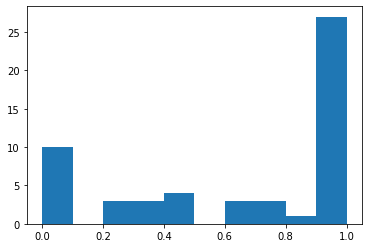

In [33]:
plt.hist(psix_object.adata.uns['psi'].loc[meta.index[meta.cell_type == 'Motor neuron'], 'Cadm1_9'])

In [54]:
real_neurons = psix_object.adata.uns['latent'].index[(psix_object.adata.uns['latent'].PC_1 > 60) & (psix_object.adata.uns['latent'].PC_2 < -40)]